# ANOVA

Table of contents

Intro

In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [14]:
%matplotlib inline

In [15]:
# Define the path to the CSV file
csv_file_path = r'data\flavors_of_cacao.csv'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Display the first few rows to verify
print("First few rows of the dataset:")
display(df.head())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


First few rows of the dataset:


,Company,Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru



Missing Values in Each Column:
Company                             0
Specific Bean Origin or Bar Name    0
REF                                 0
Review Date                         0
Cocoa Percent                       0
Company Location                    0
Rating                              0
Bean Type                           1
Broad Bean Origin                   1
dtype: int64


# Pre-Procesing 

In [16]:
# Drop rows with missing 'Bean Type' if it's essential; otherwise, keep them
# For this analysis, we'll keep them as we're focusing on 'Broad Bean Origin'
# But ensure 'Broad Bean Origin' and 'Rating' are not missing
df = df.dropna(subset=['Broad Bean Origin', 'Bean Type'])

# Convert 'Cocoa Percent' to float
df['Cocoa Percent'] = df['Cocoa Percent'].str.rstrip('%').astype(float)

# Verify data types
print("\nData Types After Conversion:")
print(df.dtypes)


Data Types After Conversion:
Company                              object
Specific Bean Origin or Bar Name     object
REF                                   int64
Review Date                           int64
Cocoa Percent                       float64
Company Location                     object
Rating                              float64
Bean Type                            object
Broad Bean Origin                    object
dtype: object


#   EDA

In [17]:
# Display summary statistics for 'Rating' grouped by 'Broad Bean Origin'
print("\nSummary Statistics by Broad Bean Origin:")
display(df.groupby('Broad Bean Origin')['Rating'].describe())



Summary Statistics by Broad Bean Origin:


,count,mean,std,min,25%,50%,75%,max
Broad Bean Origin,,,,,,,,
"Africa, Carribean, C. Am.",1.0,2.750000,NaN,2.75,2.750,2.750,2.7500,2.75
Australia,3.0,3.250000,0.500000,2.75,3.000,3.250,3.5000,3.75
Belize,49.0,3.234694,0.320352,2.75,3.000,3.250,3.5000,4.00
Bolivia,57.0,3.197368,0.421882,2.00,3.000,3.250,3.5000,4.00
Brazil,58.0,3.284483,0.417407,1.75,3.000,3.375,3.5000,4.00
...,...,...,...,...,...,...,...,...
"Venezuela, Trinidad",1.0,2.500000,NaN,2.50,2.500,2.500,2.5000,2.50
Venezuela/ Ghana,1.0,3.500000,NaN,3.50,3.500,3.500,3.5000,3.50
Vietnam,38.0,3.315789,0.316677,2.75,3.000,3.375,3.5000,4.00


In [18]:
# Define the list of desired origin countries
selected_origins = ['Mexico', 'Colombia', 'Ghana', 'Nigeria', 'Cameroon', 'Madagascar', 'Togo', 'Uganda', 'Sierra Leone']

# Filter the DataFrame
df = df[df['Broad Bean Origin'].isin(selected_origins)].copy()

# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Check the number of entries per origin
print("Number of chocolates per Origin Country:")
print(df['Broad Bean Origin'].value_counts())


Number of chocolates per Origin Country:
Broad Bean Origin
Madagascar    145
Colombia       40
Ghana          33
Mexico         30
Uganda          8
Togo            3
Nigeria         1
Cameroon        1
Name: count, dtype: int64


C:\Users\HG_Co\AppData\Local\Temp\ipykernel_21648\3632268596.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Broad Bean Origin', y='Rating', data=df, palette="Set3")


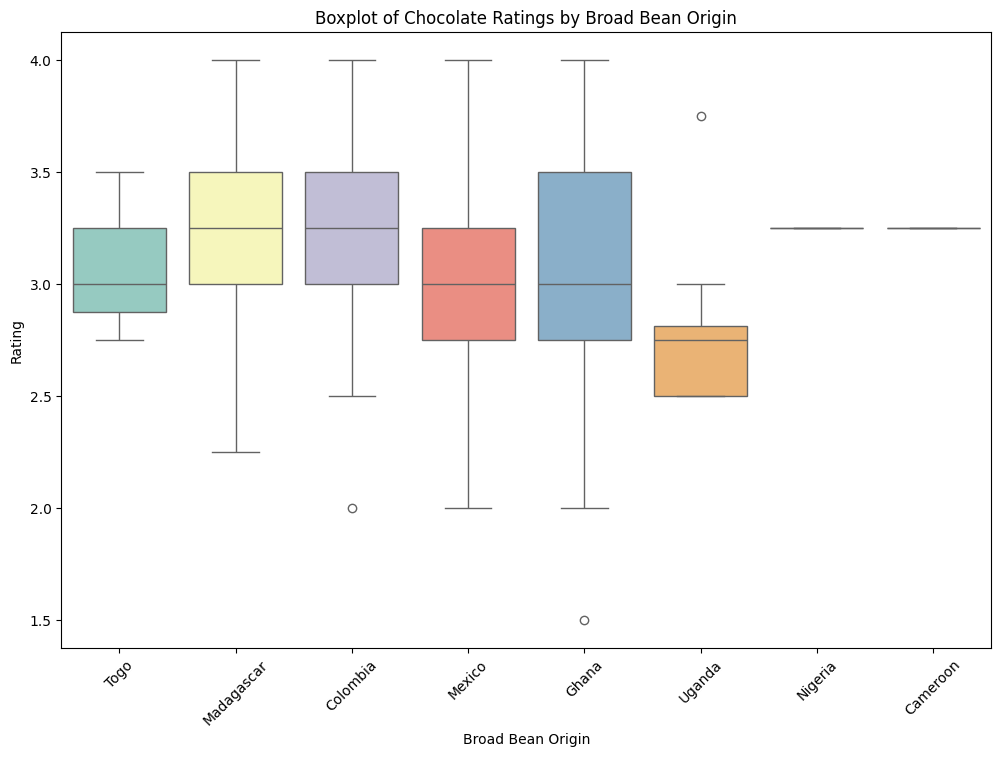

In [19]:
# Boxplot to visualize the distribution of ratings by Broad Bean Origin
plt.figure(figsize=(12, 8))
sns.boxplot(x='Broad Bean Origin', y='Rating', data=df, palette="Set3")
plt.title('Boxplot of Chocolate Ratings by Broad Bean Origin')
plt.xlabel('Broad Bean Origin')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()

C:\Users\HG_Co\AppData\Local\Temp\ipykernel_21648\4031857018.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Broad Bean Origin', y='Rating', data=df, palette="Set2")


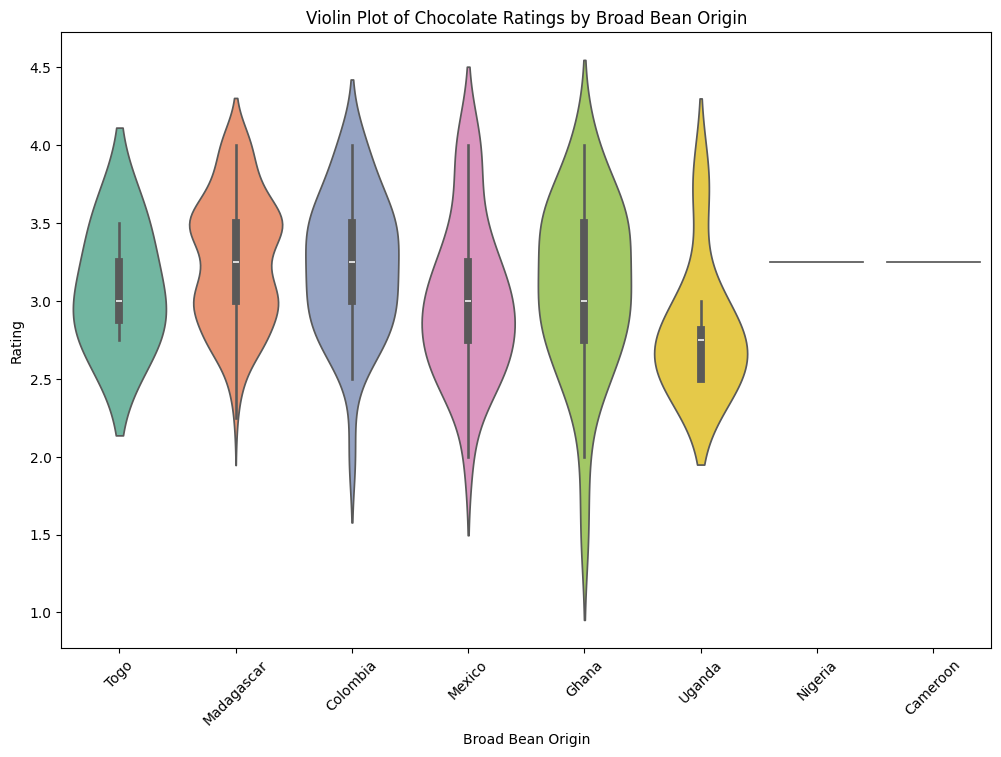

In [20]:

# Violin plot for a detailed distribution view
plt.figure(figsize=(12, 8))
sns.violinplot(x='Broad Bean Origin', y='Rating', data=df, palette="Set2")
plt.title('Violin Plot of Chocolate Ratings by Broad Bean Origin')
plt.xlabel('Broad Bean Origin')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()


# ANOVA

# Verify Assumptions

In [21]:
# Define the significance level
alpha = 0.05

print("Shapiro-Wilk Test for Normality:")
for origin in df['Broad Bean Origin'].unique():
    group_data = df[df['Broad Bean Origin'] == origin]['Rating']
    n = len(group_data)
    if n >= 3:  # Shapiro-Wilk test requires at least 3 data points
        stat, p = shapiro(group_data)
        print(f"\nOrigin: {origin}")
        print(f"Sample Size (n): {n}")
        print(f"Shapiro-Wilk Test Statistic: {stat:.3f}")
        print(f"P-Value: {p:.3f}")
        
        # Interpretation
        if p > alpha:
            print(f"Result: Fail to reject the null hypothesis (p > {alpha}).")
            print("Conclusion: The data is normally distributed.\n")
        else:
            print(f"Result: Reject the null hypothesis (p <= {alpha}).")
            print("Conclusion: The data is not normally distributed.\n")
    else:
        print(f"\nOrigin: {origin}")
        print(f"Sample Size (n): {n}")
        print("Result: Not enough data for Shapiro-Wilk test (n < 3).\n")

Shapiro-Wilk Test for Normality:

Origin: Togo
Sample Size (n): 3
Shapiro-Wilk Test Statistic: 0.964
P-Value: 0.637
Result: Fail to reject the null hypothesis (p > 0.05).
Conclusion: The data is normally distributed.


Origin: Madagascar
Sample Size (n): 145
Shapiro-Wilk Test Statistic: 0.944
P-Value: 0.000
Result: Reject the null hypothesis (p <= 0.05).
Conclusion: The data is not normally distributed.


Origin: Colombia
Sample Size (n): 40
Shapiro-Wilk Test Statistic: 0.955
P-Value: 0.109
Result: Fail to reject the null hypothesis (p > 0.05).
Conclusion: The data is normally distributed.


Origin: Mexico
Sample Size (n): 30
Shapiro-Wilk Test Statistic: 0.932
P-Value: 0.057
Result: Fail to reject the null hypothesis (p > 0.05).
Conclusion: The data is normally distributed.


Origin: Ghana
Sample Size (n): 33
Shapiro-Wilk Test Statistic: 0.938
P-Value: 0.061
Result: Fail to reject the null hypothesis (p > 0.05).
Conclusion: The data is normally distributed.


Origin: Uganda
Sample Size

In [23]:
selected_origins = ['Mexico', 'Colombia', 'Ghana', 'Togo']

# Filter the DataFrame
df = df[df['Broad Bean Origin'].isin(selected_origins)].copy()

In [29]:
# Define the significance level
alpha = 0.05

# Prepare groups based on 'Broad Bean Origin'
groups = [df[df['Broad Bean Origin'] == origin]['Rating'] for origin in df['Broad Bean Origin'].unique()]
group_names = df['Broad Bean Origin'].unique()

# Perform Levene's Test for Homogeneity of Variances
stat, p = levene(*groups, center='mean')

print(f"\nLevene's Test for Homogeneity of Variances:")
print(f"Test Statistic: {stat:.3f}")
print(f"P-Value: {p:.3f}")

# Interpretation of Levene's Test
if p > alpha:
    print(f"\nResult: Fail to reject the null hypothesis (p > {alpha}).")
    print("Conclusion: The variances are equal across groups (homogeneity of variances is satisfied).\n")
else:
    print(f"\nResult: Reject the null hypothesis (p <= {alpha}).")
    print("Conclusion: The variances are not equal across groups (homogeneity of variances is not satisfied).\n")



Levene's Test for Homogeneity of Variances:
Test Statistic: 0.556
P-Value: 0.645

Result: Fail to reject the null hypothesis (p > 0.05).
Conclusion: The variances are equal across groups (homogeneity of variances is satisfied).



C:\Users\HG_Co\AppData\Local\Temp\ipykernel_21648\1992777884.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Broad Bean Origin', y='Rating', data=df, palette="Set3")


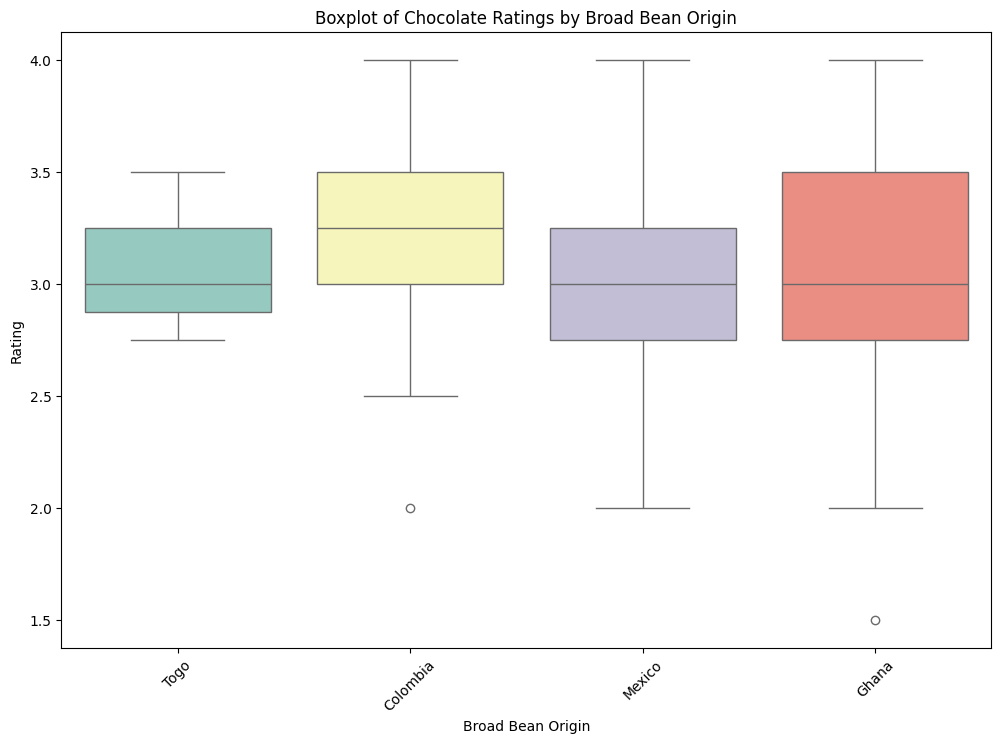

In [30]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Broad Bean Origin', y='Rating', data=df, palette="Set3")
plt.title('Boxplot of Chocolate Ratings by Broad Bean Origin')
plt.xlabel('Broad Bean Origin')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()


## One-Way ANOVA

ANOVA Table:


,sum_sq,df,F,PR(>F)
C(Broad_Bean_Origin),0.846587,3.0,1.16044,0.328642
Residual,24.804356,102.0,NaN,NaN


P-Value from ANOVA: 0.3286
Result: Fail to reject the null hypothesis (p >= 0.05).
Conclusion: There is no statistically significant difference in chocolate ratings among the different Broad Bean Origins.

Effect Size (Eta Squared): 0.0330
Interpretation: The effect size is considered small.



C:\Users\HG_Co\AppData\Local\Temp\ipykernel_21648\964476021.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table["PR(>F)"][0]
C:\Users\HG_Co\AppData\Local\Temp\ipykernel_21648\964476021.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum_sq = anova_table["sum_sq"][0]  # Between-group sum of squares


Tukey's HSD Post-hoc Test Results:


group1,group2,meandiff,p-adj,lower,upper,reject
Colombia,Ghana,-0.1341,0.6556,-0.437,0.1688,False
Colombia,Mexico,-0.2167,0.2704,-0.5278,0.0944,False
Colombia,Togo,-0.1417,0.9634,-0.9127,0.6293,False
Ghana,Mexico,-0.0826,0.9104,-0.4075,0.2423,False
Ghana,Togo,-0.0076,1.0,-0.7843,0.7691,False
Mexico,Togo,0.075,0.9944,-0.7049,0.8549,False


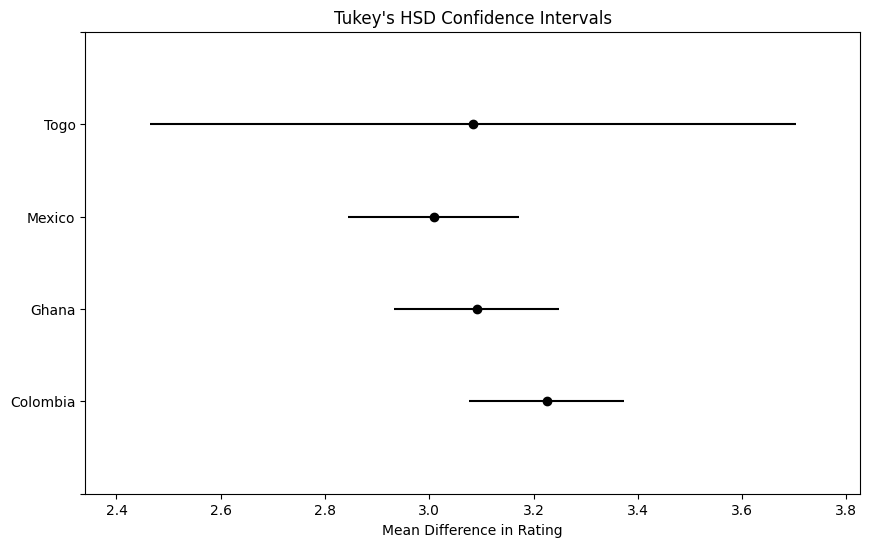

In [37]:
# One-Way ANOVA using backticks to handle spaces in column names
# Rename 'Broad Bean Origin' to 'Broad_Bean_Origin'
df.rename(columns={'Broad Bean Origin': 'Broad_Bean_Origin'}, inplace=True)

# Fit the OLS model with backticks around 'Broad Bean Origin'
model = ols('Rating ~ C(Broad_Bean_Origin)', data=df).fit()

# Perform ANOVA
anova_table = anova_lm(model, typ=2)

# Display the ANOVA table
print("ANOVA Table:")
display(anova_table)

# Interpretation of ANOVA results
p_value = anova_table["PR(>F)"][0]

print(f"P-Value from ANOVA: {p_value:.4f}")

if p_value < alpha:
    print(f"Result: Reject the null hypothesis (p < {alpha}).")
    print("Conclusion: There is a statistically significant difference in chocolate ratings among the different Broad Bean Origins.\n")
else:
    print(f"Result: Fail to reject the null hypothesis (p >= {alpha}).")
    print("Conclusion: There is no statistically significant difference in chocolate ratings among the different Broad Bean Origins.\n")

# Calculate Eta Squared (η²) for effect size
sum_sq = anova_table["sum_sq"][0]  # Between-group sum of squares
total_sum_sq = anova_table["sum_sq"].sum()

eta_squared = sum_sq / total_sum_sq

print(f"Effect Size (Eta Squared): {eta_squared:.4f}")

# Interpretation of Effect Size
if eta_squared < 0.01:
    effect_size = "negligible"
elif eta_squared < 0.06:
    effect_size = "small"
elif eta_squared < 0.14:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"Interpretation: The effect size is considered {effect_size}.\n")

# Post-hoc Test (Tukey's HSD)
tukey = pairwise_tukeyhsd(endog=df['Rating'],
                          groups=df['Broad_Bean_Origin'],
                          alpha=0.05)

# Display the Tukey HSD results
print("Tukey's HSD Post-hoc Test Results:")
display(tukey.summary())

# Visualize Tukey's HSD Results
tukey.plot_simultaneous(figsize=(10,6))
plt.title("Tukey's HSD Confidence Intervals")
plt.xlabel('Mean Difference in Rating')
plt.show()


### Interpretation

### Effect Size

## Post-hoc Test (Tukey's HSD)

### Visualize Results 

## Conclusions 

No Significant Pairwise Differences:

All reject values are False.
Implication: There are no statistically significant differences in chocolate ratings between any pair of Broad Bean Origins at the α = 0.05 level.
p-adj Values:

All p-adj values are greater than 0.05, indicating that none of the group comparisons reached statistical significance after adjusting for multiple comparisons.
Confidence Intervals:

All confidence intervals include zero (e.g., -0.437 to 0.1688 for Colombia vs. Ghana).
Implication: There's no evidence to suggest a true difference in means between the compared groups.
Mean Differences:

While there are variations in mean differences (ranging from -0.2167 to 0.0750), these differences are not large enough to be considered statistically significant given the variability and sample sizes in your data.